<a href="https://colab.research.google.com/github/towardsai/ai-tutor-rag-system/blob/main/notebooks/05-Improve_Prompts_+_Add_Source.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Packages and Setup Variables


In [37]:
# !pip install -q llama-index==0.14.0 openai==1.107.0 chromadb==1.0.21 llama-index-vector-stores-chroma==0.5.2 \
#                 llama-index-llms-google-genai==0.3.0 jedi==0.19.2

In [38]:
import os

# Set the following API Keys in the Python environment. Will be used later.
# os.environ["OPENAI_API_KEY"] = "<YOUR_API_KEY>"
# os.environ["GOOGLE_API_KEY"] = "<YOUR_API_KEY>"

# from google.colab import userdata
# os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
# os.environ["GOOGLE_API_KEY"] = userdata.get('Google_api_key')

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), override=True)  # override=True to overwrite existing environment variables

True

In [39]:
# Allows running asyncio in environments with an existing event loop, like Jupyter notebooks.

import nest_asyncio

nest_asyncio.apply()

In [40]:
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core import Settings

Settings.embed_model = OpenAIEmbedding(
    model="text-embedding-3-small"
)

# Create a VectoreStore


In [41]:
# import chromadb

# # create client and a new collection
# # chromadb.EphemeralClient saves data in-memory.
# chroma_client = chromadb.PersistentClient(path="./mini-llama-articles")
# chroma_collection = chroma_client.create_collection("mini-llama-articles")

from qdrant_client import QdrantClient, models as qdrant_models

qdrant_client = QdrantClient(url=f"{os.getenv('qdrant_server_id')}:6333")

collection_name = "mini-llama-articles_05"

In [42]:
print(qdrant_client.get_collections().model_dump_json())

{"collections":[{"name":"chat_with_docs"},{"name":"mini-chunked-dataset_langchain"},{"name":"graphRAGstoreds"},{"name":"Part3_DDofDS_1_10"},{"name":"Part3_DDofDS_SQuAD_qb"},{"name":"Part3_DDofDS"},{"name":"mini-llama-articles"},{"name":"Part3_DDofDS_SQuAD"},{"name":"graphRAG_FIXED_test"},{"name":"mini-chunked-dataset"},{"name":"Part6-linkedin-posts"},{"name":"Part4_Attention"},{"name":"scifact"},{"name":"document_chat"}]}


In [43]:
# qdrant_client.recreate_collection(
#     collection_name=collection_name,
#     vectors_config=qdrant_models.VectorParams(
#         size=1536,  # Size of the embedding vectors
#         distance=qdrant_models.Distance.COSINE  # Distance metric
#     )
# )

In [102]:
if qdrant_client.collection_exists(collection_name=collection_name):
    print(f"Collection '{collection_name}' already exists.")
else:
    collection_name = "mini-llama-articles"
    qdrant_client.create_collection(
        collection_name=collection_name,
        vectors_config=qdrant_models.VectorParams(
            size=1536,  # Size of the embedding vectors
            distance=qdrant_models.Distance.COSINE  # Distance metric
        )
    )
    print(f"Collection '{collection_name}' created.")

Collection 'mini-llama-articles' created.


In [46]:
# from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.vector_stores.qdrant import QdrantVectorStore

# Define a storage context object using the created vector database.
# vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
vector_store = QdrantVectorStore(
	client=qdrant_client,
	collection_name="mini-llama-articles")

# Load the Dataset (CSV)


## Download


The dataset includes several articles from the TowardsAI blog, which provide an in-depth explanation of the LLaMA2 model.


In [ ]:
# !curl -o ./mini-dataset.csv https://raw.githubusercontent.com/AlaFalaki/tutorial_notebooks/main/data/mini-llama-articles.csv

## Load the Articles


In [47]:
import csv

rows = []

# Load the file as a JSON
with open("./mini-llama-articles.csv", mode="r", encoding="utf-8") as file:
    csv_reader = csv.reader(file)

    for idx, row in enumerate(csv_reader): # if idx > 0:
        if idx == 0:
            continue
            # Skip header row
        rows.append(row)

# The number of characters in the dataset.
len(rows)

14

# Convert to Document obj


In [48]:
from llama_index.core import Document

# Convert the chunks to Document objects so the LlamaIndex framework can process them.
documents = [
    Document(
        text=row[1], metadata={"title": row[0], "url": row[2], "source_name": row[3]}
    )
    for row in rows
]

In [ ]:
len(documents)

14

In [ ]:
print(documents[0].text)
documents[0].metadata

LLM Variants and Meta's Open Source Before shedding light on four major trends, I'd share the latest Meta's Llama 2 and Code Llama. Meta's Llama 2 represents a sophisticated evolution in LLMs. This suite spans models pretrained and fine-tuned across a parameter spectrum of 7 billion to 70 billion. A specialized derivative, Llama 2-Chat, has been engineered explicitly for dialogue-centric applications. Benchmarking revealed Llama 2's superior performance over most extant open-source chat models. Human-centric evaluations, focusing on safety and utility metrics, positioned Llama 2-Chat as a potential contender against proprietary, closed-source counterparts. The development trajectory of Llama 2 emphasized rigorous fine-tuning methodologies. Meta's transparent delineation of these processes aims to catalyze community-driven advancements in LLMs, underscoring a commitment to collaborative and responsible AI development. Code Llama is built on top of Llama 2 and is available in three model

{'title': "Beyond GPT-4: What's New?",
 'url': 'https://pub.towardsai.net/beyond-gpt-4-whats-new-cbd61a448eb9#dda8',
 'source_name': 'towards_ai'}

# Transforming


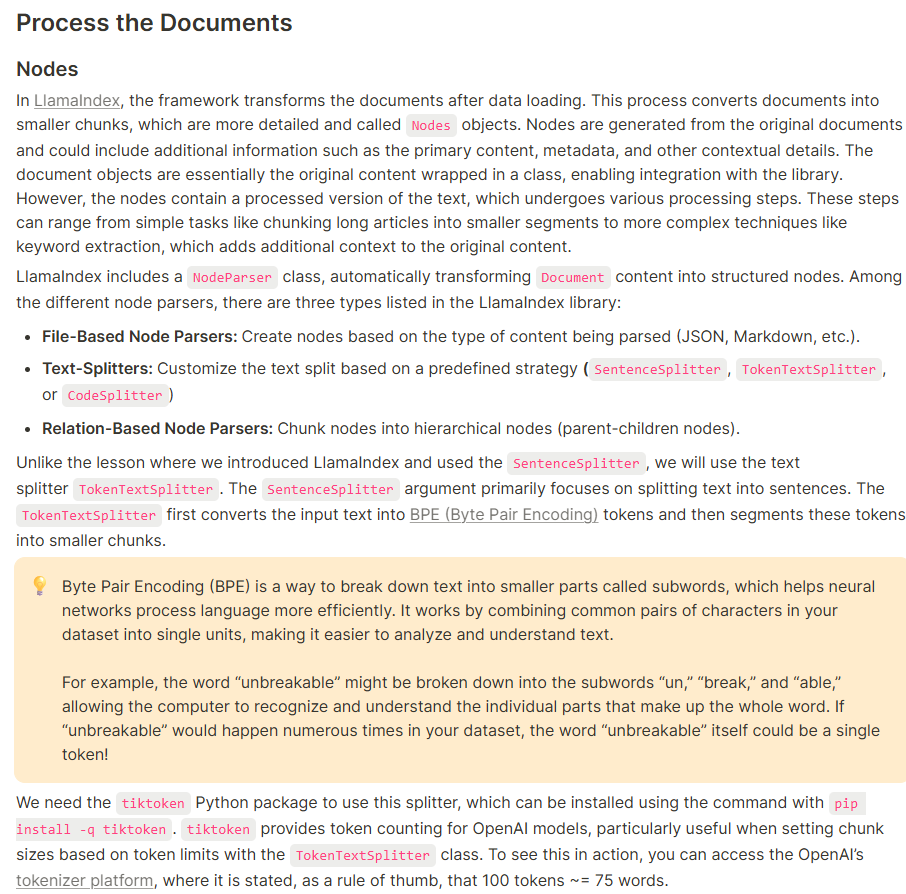

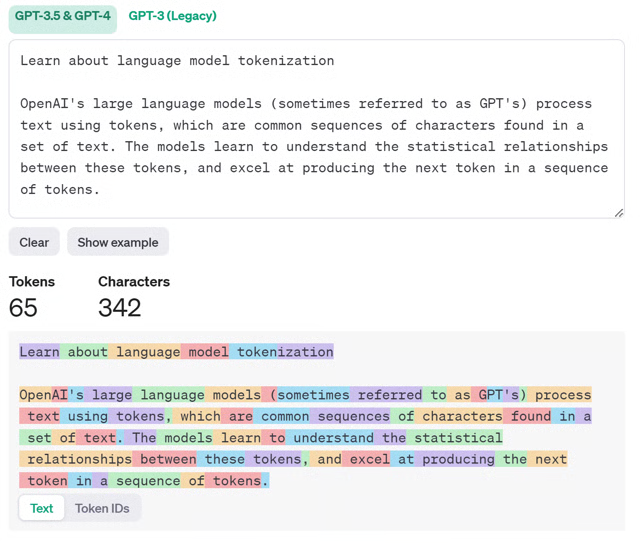

In [49]:
from llama_index.core.node_parser import TokenTextSplitter

# Define the splitter object that split the text into segments with 512 tokens,
# with a 128 overlap between the segments.
text_splitter = TokenTextSplitter(separator=" ", chunk_size=512, chunk_overlap=128)

In [ ]:
text_splitter.to_json()

'{"include_metadata": true, "include_prev_next_rel": true, "chunk_size": 512, "chunk_overlap": 128, "separator": " ", "backup_separators": ["\\n"], "class_name": "TokenTextSplitter"}'

In [ ]:
text_splitter

TokenTextSplitter(include_metadata=True, include_prev_next_rel=True, callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x000001C8A1A15A70>, id_func=<function default_id_func at 0x000001C89A8D2AC0>, chunk_size=512, chunk_overlap=128, separator=' ', backup_separators=['\n'])

In [ ]:
print(type(text_splitter), len(text_splitter.split_text(documents[0].text)))

<class 'llama_index.core.node_parser.text.token.TokenTextSplitter'> 5


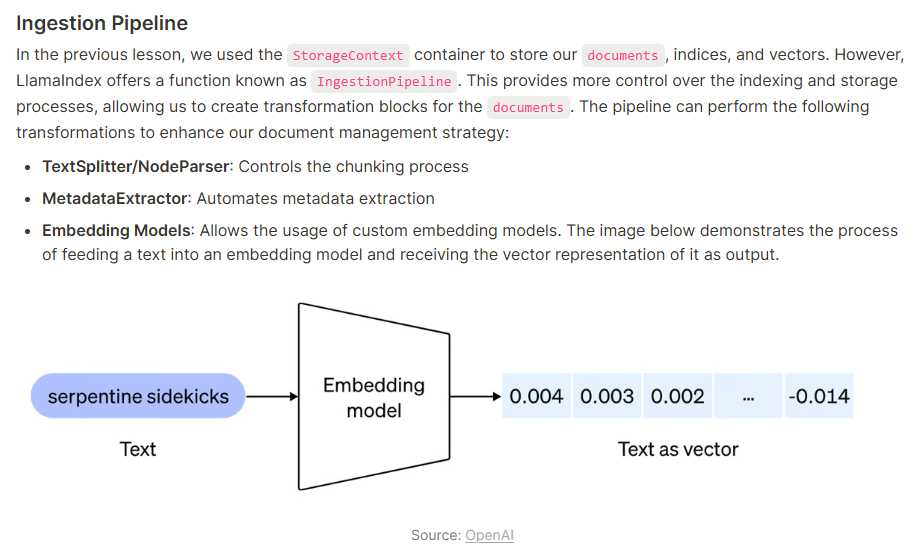

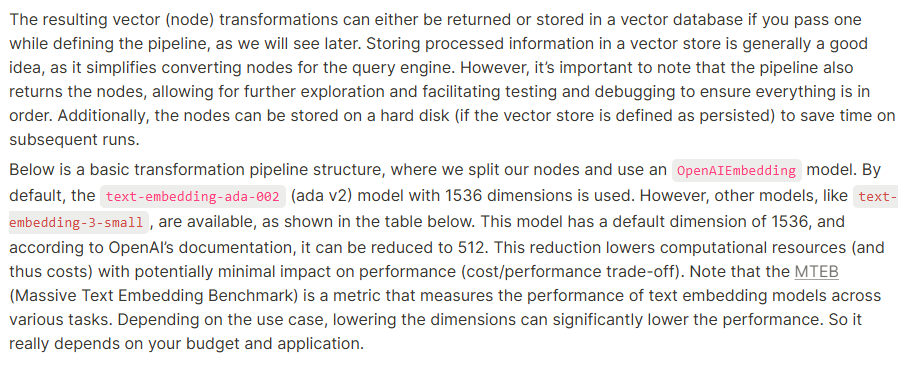

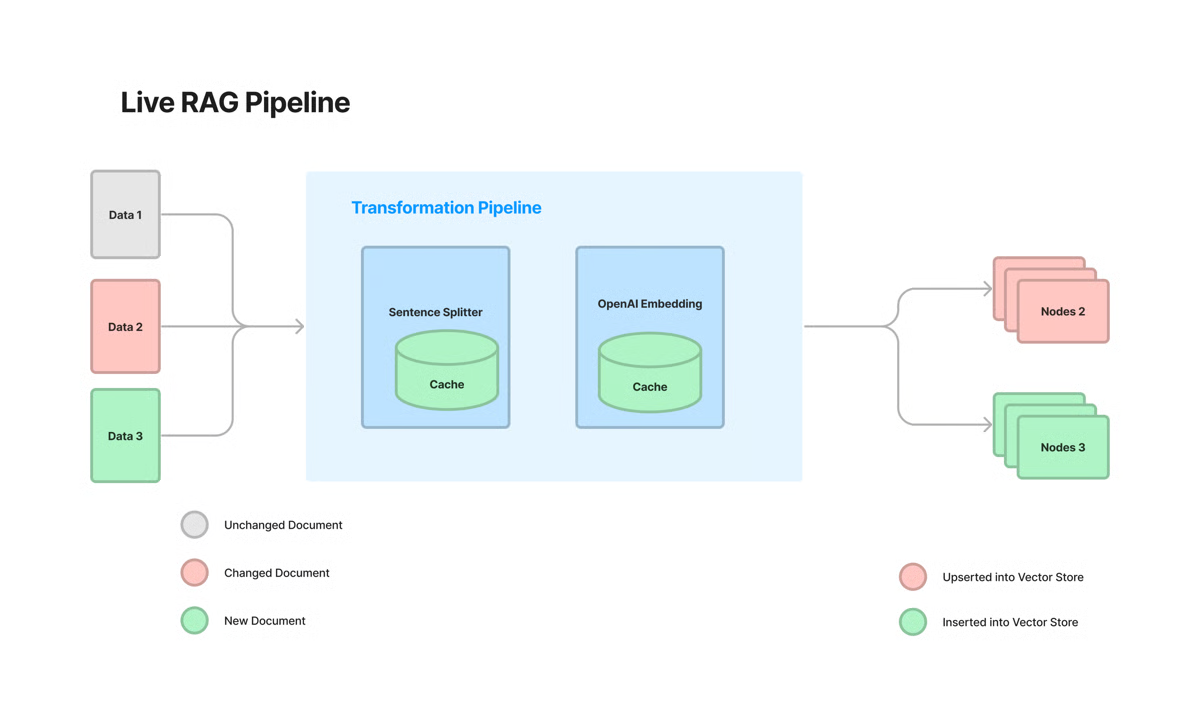

In [51]:
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core.ingestion import IngestionPipeline

# Create the pipeline to apply the transformation (splitting and embedding) on each chunk,
# and store the transformed text in the chroma vector store.
pipeline = IngestionPipeline(
    transformations=[
        text_splitter,
        OpenAIEmbedding(model = 'text-embedding-3-small'),
    ],
    vector_store=vector_store,
)

In [103]:
# Run the transformation pipeline.
b = pipeline.run(documents=documents, show_progress=True)

## QDRANT record deletion examples

In [ ]:
from qdrant_client.models import Filter, FieldCondition, MatchValue, Range

In [57]:
del_collection_name = "mini-llama-articles"
del_collection = qdrant_client.get_collection(collection_name=del_collection_name)

In [58]:
del_collection

CollectionInfo(status=<CollectionStatus.GREEN: 'green'>, optimizer_status=<OptimizersStatusOneOf.OK: 'ok'>, vectors_count=None, indexed_vectors_count=0, points_count=216, segments_count=3, config=CollectionConfig(params=CollectionParams(vectors=VectorParams(size=1536, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=None), shard_number=1, sharding_method=None, replication_factor=1, write_consistency_factor=1, read_fan_out_factor=None, on_disk_payload=True, sparse_vectors=None), hnsw_config=HnswConfig(m=16, ef_construct=100, full_scan_threshold=10000, max_indexing_threads=0, on_disk=False, payload_m=None), optimizer_config=OptimizersConfig(deleted_threshold=0.2, vacuum_min_vector_number=1000, default_segment_number=0, max_segment_size=None, memmap_threshold=None, indexing_threshold=10000, flush_interval_sec=5, max_optimization_threads=None), wal_config=WalConfig(wal_capacity_mb=32, wal_segments_ahead=0), qu

In [66]:
import os
from qdrant_client import QdrantClient
from qdrant_client.models import Filter, FieldCondition, MatchValue
from openai import OpenAI

# Embed the query
client_oa = OpenAI(  # or base_url="https://openrouter.ai/api/v1" with OpenRouter key
    api_key=os.getenv("OPENAI_API_KEY"),
)

def query_embed(query: str) -> list[float]:
    return (
        client_oa.embeddings.create(
            model="text-embedding-3-small",
            input=query,
        )
        .data[0]
        .embedding
    )  # list[float], len=1536

query = "What is LlamaIndex?"

# Search in Qdrant
# qdrant = QdrantClient(url="http://localhost:6333")

def get_records(query: str, top_k: int = 3):

    hits = qdrant_client.query_points(
        collection_name=del_collection_name,
        query=query_embed(query),
        limit=top_k,
        with_payload=True,
        # Optional metadata filter:
        # filter=Filter(must=[FieldCondition(key="source", match=MatchValue(value="blog"))]),
    )

    return hits.points

In [67]:
hits = get_records(query, top_k=3)

In [75]:
rec0 = next(hit for hit in iter(hits)) # list of records iter()
rec0

ScoredPoint(id='0b1d1d5a-d23a-4545-a04d-d7d042ee5792', version=0, score=0.45502162, payload={'title': "Inside Code Llama: Meta AI's Entrance in the Code LLM Space", 'url': 'https://pub.towardsai.net/inside-code-llama-meta-ais-entrance-in-the-code-llm-space-9f286d13a48d#c9e0', 'source_name': 'towards_ai', '_node_content': '{"id_": "0b1d1d5a-d23a-4545-a04d-d7d042ee5792", "embedding": null, "metadata": {"title": "Inside Code Llama: Meta AI\'s Entrance in the Code LLM Space", "url": "https://pub.towardsai.net/inside-code-llama-meta-ais-entrance-in-the-code-llm-space-9f286d13a48d#c9e0", "source_name": "towards_ai"}, "excluded_embed_metadata_keys": [], "excluded_llm_metadata_keys": [], "relationships": {"1": {"node_id": "ca76cd4e-81c0-4fec-8bbb-653b641a11ee", "node_type": "4", "metadata": {"title": "Inside Code Llama: Meta AI\'s Entrance in the Code LLM Space", "url": "https://pub.towardsai.net/inside-code-llama-meta-ais-entrance-in-the-code-llm-space-9f286d13a48d#c9e0", "source_name": "towa

In [76]:
rec0.payload

{'title': "Inside Code Llama: Meta AI's Entrance in the Code LLM Space",
 'url': 'https://pub.towardsai.net/inside-code-llama-meta-ais-entrance-in-the-code-llm-space-9f286d13a48d#c9e0',
 'source_name': 'towards_ai',
 '_node_content': '{"id_": "0b1d1d5a-d23a-4545-a04d-d7d042ee5792", "embedding": null, "metadata": {"title": "Inside Code Llama: Meta AI\'s Entrance in the Code LLM Space", "url": "https://pub.towardsai.net/inside-code-llama-meta-ais-entrance-in-the-code-llm-space-9f286d13a48d#c9e0", "source_name": "towards_ai"}, "excluded_embed_metadata_keys": [], "excluded_llm_metadata_keys": [], "relationships": {"1": {"node_id": "ca76cd4e-81c0-4fec-8bbb-653b641a11ee", "node_type": "4", "metadata": {"title": "Inside Code Llama: Meta AI\'s Entrance in the Code LLM Space", "url": "https://pub.towardsai.net/inside-code-llama-meta-ais-entrance-in-the-code-llm-space-9f286d13a48d#c9e0", "source_name": "towards_ai"}, "hash": "6dfe86f3d9f69f8967bbf69ab1627c07cd6036945655f42b64a570b67beac088", "cl

In [ ]:
rec0.

'{"id":"0b1d1d5a-d23a-4545-a04d-d7d042ee5792","version":0,"score":0.45502162,"payload":{"title":"Inside Code Llama: Meta AI\'s Entrance in the Code LLM Space","url":"https://pub.towardsai.net/inside-code-llama-meta-ais-entrance-in-the-code-llm-space-9f286d13a48d#c9e0","source_name":"towards_ai","_node_content":"{\\"id_\\": \\"0b1d1d5a-d23a-4545-a04d-d7d042ee5792\\", \\"embedding\\": null, \\"metadata\\": {\\"title\\": \\"Inside Code Llama: Meta AI\'s Entrance in the Code LLM Space\\", \\"url\\": \\"https://pub.towardsai.net/inside-code-llama-meta-ais-entrance-in-the-code-llm-space-9f286d13a48d#c9e0\\", \\"source_name\\": \\"towards_ai\\"}, \\"excluded_embed_metadata_keys\\": [], \\"excluded_llm_metadata_keys\\": [], \\"relationships\\": {\\"1\\": {\\"node_id\\": \\"ca76cd4e-81c0-4fec-8bbb-653b641a11ee\\", \\"node_type\\": \\"4\\", \\"metadata\\": {\\"title\\": \\"Inside Code Llama: Meta AI\'s Entrance in the Code LLM Space\\", \\"url\\": \\"https://pub.towardsai.net/inside-code-llama-m

In [77]:

for h in hits:
    print(h.id, h.score, h.payload.get("title"))


0b1d1d5a-d23a-4545-a04d-d7d042ee5792 0.45502162 Inside Code Llama: Meta AI's Entrance in the Code LLM Space
31588448-7d61-4da2-974d-ffb8a7bb31ce 0.4549306 Inside Code Llama: Meta AI's Entrance in the Code LLM Space
97e8e304-be60-4a87-9451-9ac778bd6d57 0.45433646 Inside Code Llama: Meta AI's Entrance in the Code LLM Space


A) Filter-only retrieval (no embeddings)

Use scroll to page through results that match a payload filter.

 * should: description="At least one of those conditions should match"
 * min_should: description="At least minimum amount of given conditions should match"
 * must: description="All conditions must match"
 * must_not: description="All conditions must NOT match"
 * 

In [ ]:
flt = Filter(
    must=[
        FieldCondition(key="source", match=MatchValue(value="blog")),
        FieldCondition(key="lang", match=MatchValue(value="en")),
    ]
)

offset = None
all_points = []
while True:
    next_page, points, next_offset = client.scroll(
        collection_name=collection,
        with_payload=True,
        with_vectors=False,  # set True if you want vectors back
        limit=100,  # page size
        filter=flt,
        offset=offset,  # pagination
    )
    all_points.extend(points)
    if next_offset is None:
        break
    offset = next_offset

for p in all_points[:5]:
    print(p.id, p.payload)


In [ ]:
f = Filter(
    must=[
        FieldCondition(key="source", match=MatchValue(value="blog")),
    ]
)
client.delete(collection_name=collection, points_selector=f)


# Load Indexes


In [85]:
# Load the vector store from the local storage.
# db = chromadb.PersistentClient(path="./mini-llama-articles")
# chroma_collection = db.get_or_create_collection("mini-llama-articles")
# vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
from llama_index.vector_stores.qdrant import QdrantVectorStore

# Define a storage context object using the created vector database.
vector_store = QdrantVectorStore(
	client=qdrant_client,
	collection_name="mini-llama-articles")

## REPEAT FROM HERE FOR NEW NOTEBOOKS !!!

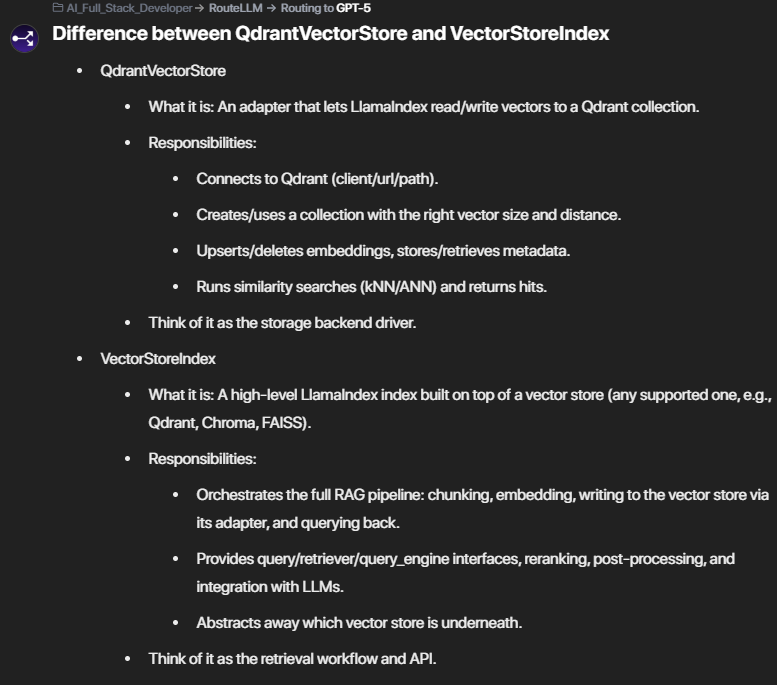

In [86]:
from llama_index.core import VectorStoreIndex

# Create the index based on the vector store.
index = VectorStoreIndex.from_vector_store(vector_store)

In [104]:
# Define a query engine that is responsible for retrieving related pieces of text,
# and using a LLM to formulate the final answer.

# from llama_index.llms.google_genai import GoogleGenAI
# import google.genai.types as types

# config = types.GenerateContentConfig(
#     thinking_config=types.ThinkingConfig(thinking_budget=0),
#     max_output_tokens=512,
#     temperature=1,
# )

# llm = GoogleGenAI(
#     model="gemini-2.5-flash",
#     generation_config=config,
#     )

from llama_index.llms.openai import OpenAI

# llm_openai = OpenAI(
#     model="gpt-4.1",
#     api_key=os.getenv("OPENAI_API_KEY"),
#     temperature=0,
#     max_tokens=512,
# )

# ValueError: Unknown model 'gpt-4.1'. Please provide a valid OpenAI model name in: gpt-4, gpt-4-32k, gpt-4-1106-preview, gpt-4-0125-preview, gpt-4-turbo-preview, gpt-4-vision-preview, gpt-4-1106-vision-preview, gpt-4-turbo-2024-04-09, gpt-4-turbo, gpt-4o, gpt-4o-2024-05-13, gpt-4o-mini, gpt-4o-mini-2024-07-18, gpt-4-0613, gpt-4-32k-0613, gpt-4-0314, gpt-4-32k-0314, gpt-3.5-turbo, gpt-3.5-turbo-16k, gpt-3.5-turbo-0125, gpt-3.5-turbo-1106, gpt-3.5-turbo-0613, gpt-3.5-turbo-16k-0613, gpt-3.5-turbo-0301, text-davinci-003, text-davinci-002, gpt-3.5-turbo-instruct, text-ada-001, text-babbage-001, text-curie-001, ada, babbage, curie, davinci, gpt-35-turbo-16k, gpt-35-turbo, gpt-35-turbo-0125, gpt-35-turbo-1106, gpt-35-turbo-0613, gpt-35-turbo-16k-0613

llm_openai = OpenAI(
    model="gpt-4",
    api_key=os.getenv("OPENAI_API_KEY"),
    temperature=0,
    max_tokens=512,
)

query_engine_openai = index.as_query_engine(llm=llm_openai, similarity_top_k=5)


In [105]:
res = query_engine_openai.query("How many parameters LLaMA2 model has?")

In [100]:
res.response

'The LLaMA 2 model is available in four different sizes: 7 billion, 13 billion, 34 billion, and 70 billion parameters.'

In [53]:
[r for r in dir(res) if not r.startswith("_")]

['get_formatted_sources', 'metadata', 'response', 'source_nodes']

In [106]:
# Show the retrieved nodes
for src in res.source_nodes:
    print("Node ID\t", src.node_id)
    print("Title\t", src.metadata["title"])
    print("URL\t", src.metadata["url"])
    print("Text\t", src.text)
    print("Score\t", src.score)
    print("-_" * 20)

Node ID	 8ad4aa6e-e56e-472f-97b4-ffe48dfbc499
Title	 Fine-Tuning a Llama-2 7B Model for Python Code Generation
URL	 https://pub.towardsai.net/fine-tuning-a-llama-2-7b-model-for-python-code-generation-865453afdf73#bf4e
Text	 only fine-tuning a small number of additional parameters, with virtually all model parameters remaining frozen. PEFT has been found to produce good generalization with relatively low-volume datasets. Furthermore, it enhances the reusability and portability of the model, as the small checkpoints obtained can be easily added to the base model, and the base model can be easily fine-tuned and reused in multiple scenarios by adding the PEFT parameters. Finally, since the base model is not adjusted, all the knowledge acquired in the pre-training phase is preserved, thus avoiding catastrophic forgetting. Most widely used PEFT techniques aim to keep the pre-trained base model untouched and add new layers or parameters on top of it. These layers are called "Adapters" and the

In [92]:
from llama_index.llms.openrouter import OpenRouter

# !pip install llama-index-llms-openrouter
llm_openrouter = OpenRouter(
    model="google/gemini-2.5-flash",
    max_tokens=512,
    temperature=1,
    api_key=os.getenv("OPENROUTER_API_KEY"),
)


In [ ]:
# Gemini via OpenRouter is used ONLY to GENERATE the ANSWER !!
# The embeddings are generated using the OpenAI API that we have already set up above via Settings.embed_model parameter of LlamaIndex package.

# Settings.embed_model = OpenAIEmbedding(model="text-embedding-3-small")


In [93]:
# query_engine_openai = index.as_query_engine(llm=llm_openai, similarity_top_k=5)
query_engine_openrouter = index.as_query_engine(llm=llm_openrouter, similarity_top_k=5)

In [94]:
res = query_engine_openrouter.query("How many parameters LLaMA2 model has?")
res.response

'The Llama 2 model is available in various sizes, specifically 7 billion, 13 billion, 34 billion, and 70 billion parameters. However, the 34-billion-parameter model has not yet been released.'

# Response Modes


The behavior of the query engine during response generation can be adjusted. Several modes are available for consideration, including the following:

- compact (default): Concatenate all the retrieved chunks and use them in the prompt to generate an answer.
- refine: Generate an answer based on the first retrieved chunk, then improve the answer based on the other retrieved chunks one at a time. (will send one request for each chunk to refine the response)
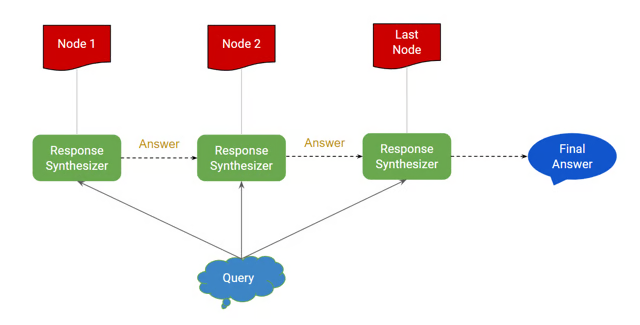
- tree summarize: concatenate the retrieved chunks until they fit the context window and summarize them. The summaized chunks will then recusively fed back to the LLM for summarization until one chunk remains which would be the final answer.

Refer to [documentation](https://docs.llamaindex.ai/en/stable/module_guides/querying/response_synthesizers/root.html#configuring-the-response-mode) for a comprehensive list.

Due to the limited size of the sample dataset, the examples provided will yield identical responses. It's crucial to evaluate these methods in the context of your specific use case and cost considerations.


## TOP-1 -> NO CORRECT ANSWER AT ALL

In [114]:
query_engine_compact_top_1  = index.as_query_engine(response_mode="compact", llm=llm_openrouter)
#query_engine = index.as_query_engine(response_mode="tree_summarize")
query_engine_refine_top_1 = index.as_query_engine(response_mode="refine", llm=llm_openrouter)
query_engine_tree_summarize_top_1 = index.as_query_engine(response_mode="tree_summarize", llm=llm_openrouter)

In [116]:
res_compact_1 = query_engine_compact_top_1.query("How many parameters LLaMA 2 model has?")
res_refine_1 = query_engine_refine_top_1.query("How many parameters LLaMA 2 model has?")
res_tree_summarize_1 = query_engine_tree_summarize_top_1.query("How many parameters LLaMA 2 model has?")
#res = query_engine.query("How many parameters LLaMA 2 model has?")

In [ ]:
print("Compact:", res_compact_1.response)
print("Refine:", res_refine.response)
print("Tree summarize:", res_tree_summarize_1.response)

Compact: This question cannot be answered from the given context. The provided text refers to fine-tuning a "Llama-2 7B model" but does not explicitly state the total number of parameters the LLaMA 2 model has.
Refine: The parameter count for the LLaMA 2 model is not mentioned.
Tree summarize: This question cannot be answered from the given context. The article references fine-tuning a Llama-2 7B model, but does not state the total number of parameters for the Llama-2 model itself.


## TOP-3 - ONLY THE COMPACT RESPONSE IS PARTLY CORRECT

In [119]:
query_engine_compact_top_3 = index.as_query_engine(response_mode="compact", llm=llm_openrouter, similarity_top_k=3)
# query_engine = index.as_query_engine(response_mode="tree_summarize")
query_engine_refine_top_3 = index.as_query_engine(response_mode="refine", llm=llm_openrouter, similarity_top_k=3)
query_engine_tree_summarize_top_3 = index.as_query_engine(response_mode="tree_summarize", llm=llm_openrouter, similarity_top_k=3)

In [120]:
res_compact_3 = query_engine_compact_top_3.query("How many parameters LLaMA 2 model has?")
res_refine_3 = query_engine_refine_top_3.query("How many parameters LLaMA 2 model has?")
res_tree_summarize_3 = query_engine_tree_summarize_top_3.query("How many parameters LLaMA 2 model has?")

In [121]:
print("Compact:", res_compact_3.response)
print("Refine:", res_refine_3.response)
print("Tree summarize:", res_tree_summarize_3.response)

Compact: The LLaMA 2 model comes in two sizes: a 7B model and a 13B model.
Refine: The number of parameters for the LLaMA 2 model is not mentioned in the provided text.
Tree summarize: There is no information about how many parameters the LLaMA 2 model has.


## TOP-5 -> ALL RESPONSES ARE CORRECT

In [122]:
query_engine_compact_top_5 = index.as_query_engine(
    response_mode="compact", llm=llm_openrouter, similarity_top_k=5
)
# query_engine = index.as_query_engine(response_mode="tree_summarize")
query_engine_refine_top_5 = index.as_query_engine(
    response_mode="refine", llm=llm_openrouter, similarity_top_k=5
)
query_engine_tree_summarize_top_5 = index.as_query_engine(
    response_mode="tree_summarize", llm=llm_openrouter, similarity_top_k=5
)


In [123]:
res_compact_5 = query_engine_compact_top_5.query(
    "How many parameters LLaMA 2 model has?"
)
res_refine_5 = query_engine_refine_top_5.query("How many parameters LLaMA 2 model has?")
res_tree_summarize_5 = query_engine_tree_summarize_top_5.query(
    "How many parameters LLaMA 2 model has?"
)


In [124]:
print("Compact:", res_compact_5.response)
print("Refine:", res_refine_5.response)
print("Tree summarize:", res_tree_summarize_5.response)


Compact: The Llama 2 model comes in four different sizes: 7 billion, 13 billion, 34 billion, and 70 billion parameters.
Refine: Llama 2 models are available in various sizes, including models with 7 billion, 13 billion, 34 billion, and 70 billion parameters.
Tree summarize: The Llama 2 model is available in varying sizes, specifically with 7 billion, 13 billion, 34 billion, and 70 billion parameters.


In [81]:
# Show the retrieved nodes
for src in res.source_nodes:
    print("Node ID\t", src.node_id)
    print("Title\t", src.metadata["title"])
    print("Text\t", src.text)
    print("Score\t", src.score)
    print("-_" * 20)

NameError: name 'res' is not defined

### NO-TEXT mode (debugging) -> for Retrieval Evaluation ONLY, NO API CALLS TO LLM

The `no_text` mode will retrieve the documents, but will not send the request to the API to synthesize the final response. It is a great approach to debug the retrieved documents.


In [125]:
query_engine = index.as_query_engine(response_mode="no_text", llm=llm_openrouter)
res = query_engine.query("How many parameters LLaMA 2 model has?")

In [126]:
res.response

''

In [127]:
# Show the retrieved nodes
for src in res.source_nodes:
    print("Node ID\t", src.node_id)
    print("Title\t", src.metadata["title"])
    print("Text\t", src.text)
    print("Score\t", src.score)
    print("-_" * 20)

Node ID	 8ad4aa6e-e56e-472f-97b4-ffe48dfbc499
Title	 Fine-Tuning a Llama-2 7B Model for Python Code Generation
Text	 only fine-tuning a small number of additional parameters, with virtually all model parameters remaining frozen. PEFT has been found to produce good generalization with relatively low-volume datasets. Furthermore, it enhances the reusability and portability of the model, as the small checkpoints obtained can be easily added to the base model, and the base model can be easily fine-tuned and reused in multiple scenarios by adding the PEFT parameters. Finally, since the base model is not adjusted, all the knowledge acquired in the pre-training phase is preserved, thus avoiding catastrophic forgetting. Most widely used PEFT techniques aim to keep the pre-trained base model untouched and add new layers or parameters on top of it. These layers are called "Adapters" and the technique of their adjustment "adapter-tuning", we add these layers to the pre-trained base model and only

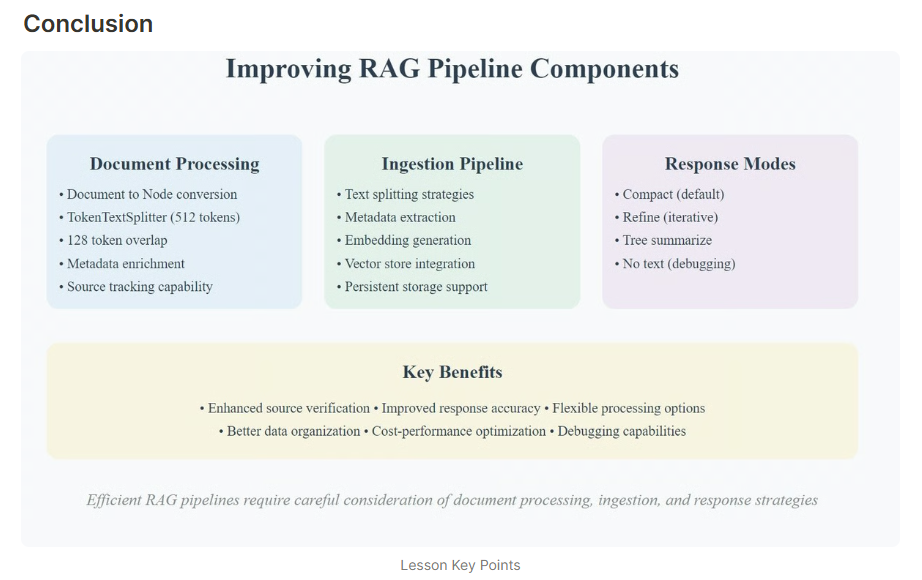